# `0 - Librerias`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import  GridSearchCV


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer


from sklearn.svm import SVC


import warnings
warnings.filterwarnings("ignore")

import joblib  
import os

# `1 - Carga de datos`

In [2]:
# Especificar la ruta al archivo donde se guardaron las variables
variable_folder = "../features"
variables_filename = os.path.join(variable_folder, "model_df_and_features.pkl")

# Cargar las variables
loaded_variables = joblib.load(variables_filename)

# Asignar las variables a los nombres originales
df_shopping = loaded_variables['df_shopping']
target = loaded_variables['target']
fea_num_model = loaded_variables['fea_num_model']
fea_cat_model = loaded_variables['fea_cat_model']
features_to_drop = loaded_variables['features_to_drop']
X_train = loaded_variables['X_train']
y_train = loaded_variables['y_train']
X_test = loaded_variables['X_test']
y_test = loaded_variables['y_test']


# `2 - Instanciar modelo ganador --> SVM (SVC)`

In [3]:
svm_model = SVC(probability=True, class_weight='balanced', random_state=42)

# `3 - Pipeline`

In [5]:
# Transformadores para datos categóricos y numéricos
cat_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

# Preprocesador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ("exclude", "drop", features_to_drop), 
        ("num", num_transformer, fea_num_model),
        ("cat", cat_transformer, fea_cat_model)
    ], remainder='passthrough'
)

# Pipeline
pipeline_imb = ImbPipeline(steps=[
    ("preprocessor", preprocessor), 
    ("smote", SMOTE(random_state=42)),
    ("classifier", svm_model) 
])

# `4 - Grid Search`

In [6]:
# Define los parámetros para GridSearch
param_grid = {
    'classifier__C': [0.1, 1, 10],  
    'classifier__kernel': ['linear', 'rbf'], 
    'classifier__gamma': ['scale', 'auto']
}

# Configurar el GridSearch
grid_search = GridSearchCV(
    estimator=pipeline_imb,
    param_grid=param_grid,
    cv=5,  # Número de folds
    scoring='balanced_accuracy',  # Métrica de evaluación
    n_jobs=-1
)

# Entrenar el GridSearch
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_


### `4.1 - Guardar modelo`

In [7]:
# Guardar el mejor modelo
model_filename = "../model/Ganador/SVM_best_model_with_proba.pkl"
joblib.dump(best_model, model_filename)
print(f"Mejor modelo SVM con probabilities=True guardado en {model_filename}")

Mejor modelo SVM con probabilities=True guardado en ../model/Ganador/SVM_best_model_with_proba.pkl


# `5 - Predicciones`

In [8]:
# Hacer predicciones con probabilidades del mejor modelo
y_pred_proba = best_model.predict_proba(X_test)
print(f"Probabilidades predichas con el mejor modelo:\n{y_pred_proba}")

Probabilidades predichas con el mejor modelo:
[[0.98981691 0.01018309]
 [0.88195589 0.11804411]
 [0.09650364 0.90349636]
 ...
 [0.12597906 0.87402094]
 [0.90906572 0.09093428]
 [0.83292412 0.16707588]]


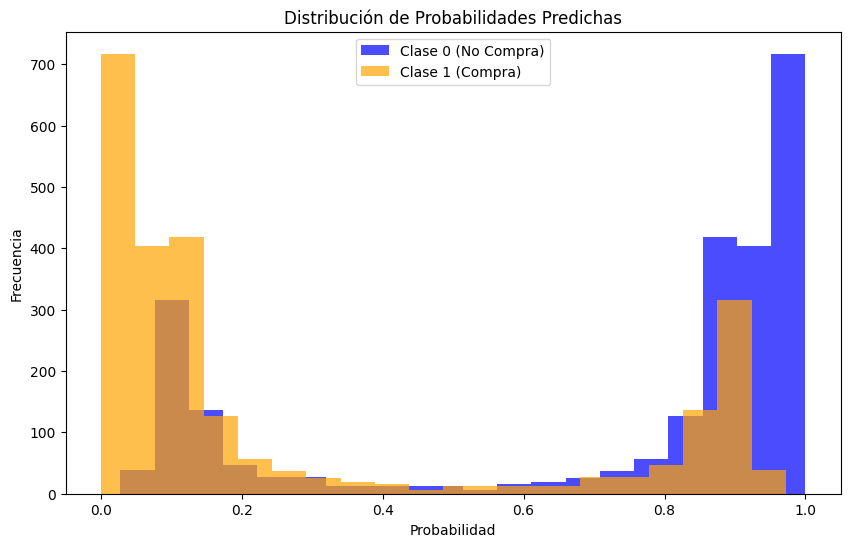

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Separar probabilidades por clase
class_0_probs = y_pred_proba[:, 0]
class_1_probs = y_pred_proba[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(class_0_probs, bins=20, alpha=0.7, label='Clase 0 (No Compra)', color='blue')
plt.hist(class_1_probs, bins=20, alpha=0.7, label='Clase 1 (Compra)', color='orange')
plt.title('Distribución de Probabilidades Predichas')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()